# Notebook dados Chile (Uruguai não tem dados da bolsa) - Contribuição Haroldo

In [2]:
# Bibliotecas que eu normalmente uso
import investpy as ipy # documentação: https://investpy.readthedocs.io/introduction.html
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from math import pi
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats  as stats
from scipy.stats import pearsonr
from sklearn import preprocessing
import seaborn as sns; sns.set()
from datetime import datetime
from datetime import date
import calendar
import os
from os import listdir
from os.path import isfile, join
import plotly.express as px
import plotly.graph_objects as go

#pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)

#pd.options.display.float_format = '{:,.2f}'.format

data_dir = '../../data/'

### Puxando dados da pandemia do Git do Prof. Celso + OurWorldinData:
https://gitlab.com/luizcelso/cdc-relatorios

https://covid.ourworldindata.org/data/ecdc/total_cases.csv

https://covid.ourworldindata.org/data/ecdc/total_deaths.csv

In [28]:
data_dir = 'data/'

# Dados de Quantidade de Casos
url_cases = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'

df_source_cases = pd.read_csv(url_cases).sort_values('date').ffill() # Preenche valores vazios com o último valor
df_orig = df_source_cases
df_orig['Day'] = df_orig.index
df_orig = df_orig.melt(['Day', 'date']).rename(columns={'date':'Date', 'value':'Total', 'variable':'Country'}) # "Alonga" a tabela transformando as colunas em dados em função das colunas que sobraram.
df_orig = df_orig[['Country', 'Date', 'Total', 'Day']]

# Dados de Quantidade de mortes
url_deaths = 'https://covid.ourworldindata.org/data/ecdc/total_deaths.csv'

df_source_deaths = pd.read_csv(url_deaths).sort_values('date').ffill()# Preenche valores vazios com o último valor
df_deaths = df_source_deaths
df_deaths['Day'] = df_deaths.index
df_deaths = df_deaths.melt(['Day', 'date']).rename(columns={'date':'Date', 'value':'TotalDeaths', 'variable':'Country'}) # "Alonga" a tabela transformando as colunas em dados em função das colunas que sobraram.
df_deaths = df_deaths[['Country', 'Date', 'TotalDeaths', 'Day']]

# Juntando mortes com Quantidade

df_orig = pd.merge(df_orig, df_deaths, how = 'left')

df_orig=df_orig[df_orig['Country']=='Brazil']

In [29]:
df_orig=df_orig[df_orig['Date']>'2020-01-19'].fillna(0)
df_orig

Country        Date      Total  Day  TotalDeaths
9344  Brazil  2020-01-20        0.0   20          0.0
9345  Brazil  2020-01-21        0.0   21          0.0
9346  Brazil  2020-01-22        0.0   22          0.0
9347  Brazil  2020-01-23        0.0   23          0.0
9348  Brazil  2020-01-24        0.0   24          0.0
...      ...         ...        ...  ...          ...
9652  Brazil  2020-11-23  6071401.0  328     169183.0
9653  Brazil  2020-11-24  6087608.0  329     169485.0
9654  Brazil  2020-11-25  6118708.0  330     170115.0
9655  Brazil  2020-11-26  6166606.0  331     170769.0
9656  Brazil  2020-11-27  6204220.0  332     171460.0

[313 rows x 5 columns]

In [18]:
# Limpando os dados

df_orig = df_orig.dropna() # não sei se é tão necessário tirar os NaNs, mas o celso estava fazendo dessa forma.
df_orig = df_orig[~df_orig['Country'].isin(['World', 'International'])]
df_orig = df_orig.sort_values(['Country', 'Date'])

df_orig.head()

Country        Date   Total  Day  TotalDeaths
9402  Brazil  2020-03-18   291.0   78          1.0
9403  Brazil  2020-03-19   428.0   79          4.0
9404  Brazil  2020-03-20   621.0   80          6.0
9405  Brazil  2020-03-21   904.0   81         11.0
9406  Brazil  2020-03-22  1128.0   82         18.0

In [4]:
# Adicionando dados diários

df_orig['TotalPrev'] = df_orig.groupby(['Country']).shift(1)['Total'].fillna(0)
df_orig['TotalDeathsPrev'] = df_orig.groupby(['Country']).shift(1)['TotalDeaths'].fillna(0)

df_orig['DailyDeaths'] = df_orig['TotalDeaths'] - df_orig['TotalDeathsPrev']
df_orig['Daily'] = df_orig['Total'] - df_orig['TotalPrev']

df_orig.drop(['TotalPrev', 'TotalDeathsPrev'], axis=1, inplace=True)

df_orig.tail()

Country        Date   Total  Day  TotalDeaths  DailyDeaths  Daily
71590  Zimbabwe  2020-11-23  9220.0  328        268.0          3.0   48.0
71591  Zimbabwe  2020-11-24  9308.0  329        273.0          5.0   88.0
71592  Zimbabwe  2020-11-25  9398.0  330        274.0          1.0   90.0
71593  Zimbabwe  2020-11-26  9508.0  331        274.0          0.0  110.0
71594  Zimbabwe  2020-11-27  9623.0  332        274.0          0.0  115.0

In [5]:
#adicionando população total de cada país
url_population = 'https://covid.ourworldindata.org/data/ecdc/locations.csv'

df_pop = pd.read_csv(url_population)[['location', 'population']].rename(columns = {'location':'Country', 'population': 'Population'})
df_orig = pd.merge(df_orig, df_pop)
df_orig.tail()

Country        Date   Total  Day  TotalDeaths  DailyDeaths  Daily  \
45731  Zimbabwe  2020-11-23  9220.0  328        268.0          3.0   48.0   
45732  Zimbabwe  2020-11-24  9308.0  329        273.0          5.0   88.0   
45733  Zimbabwe  2020-11-25  9398.0  330        274.0          1.0   90.0   
45734  Zimbabwe  2020-11-26  9508.0  331        274.0          0.0  110.0   
45735  Zimbabwe  2020-11-27  9623.0  332        274.0          0.0  115.0   

       Population  
45731  14862927.0  
45732  14862927.0  
45733  14862927.0  
45734  14862927.0  
45735  14862927.0

In [6]:
# casos e mortes a cada 100k de população.

df_orig['TotalPer100k'] = df_orig['Total'] / df_orig['Population'] * 100000
df_orig['TotalDeathsPer100k'] = df_orig['TotalDeaths'] / df_orig['Population'] * 100000
df_orig['DailyDeathsPer100k'] = df_orig['DailyDeaths'] / df_orig['Population'] * 100000
df_orig['DailyPer100k'] = df_orig['Daily'] / df_orig['Population'] * 100000
df_orig = df_orig.drop('Population', axis = 1)

df_orig.tail()

Country        Date   Total  Day  TotalDeaths  DailyDeaths  Daily  \
45731  Zimbabwe  2020-11-23  9220.0  328        268.0          3.0   48.0   
45732  Zimbabwe  2020-11-24  9308.0  329        273.0          5.0   88.0   
45733  Zimbabwe  2020-11-25  9398.0  330        274.0          1.0   90.0   
45734  Zimbabwe  2020-11-26  9508.0  331        274.0          0.0  110.0   
45735  Zimbabwe  2020-11-27  9623.0  332        274.0          0.0  115.0   

       TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  
45731     62.033542            1.803144            0.020184      0.322951  
45732     62.625619            1.836785            0.033641      0.592077  
45733     63.231152            1.843513            0.006728      0.605533  
45734     63.971249            1.843513            0.000000      0.740096  
45735     64.744986            1.843513            0.000000      0.773737

In [7]:
#Normalizando para começar a partir de 1 caso em cada país.
df_orig_start_day = df_orig[df_orig['Total'] >= 1]

df_orig_start_day.head()

Country        Date  Total  Day  TotalDeaths  DailyDeaths  Daily  \
0  Afghanistan  2020-03-24   40.0   84          1.0          1.0   40.0   
1  Afghanistan  2020-03-25   42.0   85          1.0          0.0    2.0   
2  Afghanistan  2020-03-26   75.0   86          1.0          0.0   33.0   
3  Afghanistan  2020-03-27   75.0   87          1.0          0.0    0.0   
4  Afghanistan  2020-03-28   91.0   88          2.0          1.0   16.0   

   TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  
0      0.102753            0.002569            0.002569      0.102753  
1      0.107891            0.002569            0.000000      0.005138  
2      0.192662            0.002569            0.000000      0.084771  
3      0.192662            0.002569            0.000000      0.000000  
4      0.233763            0.005138            0.002569      0.041101

In [8]:
df_orig_start_day['DayNorm'] =  df_orig_start_day[['Day']] - df_orig_start_day.groupby(['Country'])[['Day']].transform('min') + 1
df_orig_start_day.head()

Country        Date  Total  Day  TotalDeaths  DailyDeaths  Daily  \
0  Afghanistan  2020-03-24   40.0   84          1.0          1.0   40.0   
1  Afghanistan  2020-03-25   42.0   85          1.0          0.0    2.0   
2  Afghanistan  2020-03-26   75.0   86          1.0          0.0   33.0   
3  Afghanistan  2020-03-27   75.0   87          1.0          0.0    0.0   
4  Afghanistan  2020-03-28   91.0   88          2.0          1.0   16.0   

   TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  DayNorm  
0      0.102753            0.002569            0.002569      0.102753        1  
1      0.107891            0.002569            0.000000      0.005138        2  
2      0.192662            0.002569            0.000000      0.084771        3  
3      0.192662            0.002569            0.000000      0.000000        4  
4      0.233763            0.005138            0.002569      0.041101        5

In [9]:
# Cálculo das taxas de crescimento de número de casos e número de mortos
df_growth = df_orig_start_day.copy().sort_values(['Country', 'Date'])
df_growth_grouped = df_growth.groupby(['Country', 'Day']).max()[['Total', 'TotalDeaths']].sort_index()

df_growth_grouped['TotalPrev'] = df_growth_grouped.groupby(['Country']).shift(1)['Total']

df_growth_grouped['GrowthRate'] = df_growth_grouped['Total']/df_growth_grouped['TotalPrev']

df_growth_grouped['TotalPrevDeaths'] = df_growth_grouped.groupby(['Country']).shift(1)['TotalDeaths']

df_growth_grouped['GrowthRateDeaths'] = df_growth_grouped['TotalDeaths']/df_growth_grouped['TotalPrevDeaths']

df_growth_grouped = df_growth_grouped.replace([np.inf, -np.inf], np.nan)

df_growth_grouped.head()

Total  TotalDeaths  TotalPrev  GrowthRate  TotalPrevDeaths  \
Country     Day                                                               
Afghanistan 84    40.0          1.0        NaN         NaN              NaN   
            85    42.0          1.0       40.0    1.050000              1.0   
            86    75.0          1.0       42.0    1.785714              1.0   
            87    75.0          1.0       75.0    1.000000              1.0   
            88    91.0          2.0       75.0    1.213333              1.0   

                 GrowthRateDeaths  
Country     Day                    
Afghanistan 84                NaN  
            85                1.0  
            86                1.0  
            87                1.0  
            88                2.0

In [10]:
df_growth_rate = df_growth_grouped[['GrowthRate', 'GrowthRateDeaths']].dropna(subset=['GrowthRate'])
df_complete = pd.merge(df_orig_start_day, df_growth_rate.reset_index(), how='left')

df_complete['DaysToDouble'] = df_complete['GrowthRate'].apply(lambda x: math.log(2, x) if x > 1 else x)
df_complete['DaysToDoubleDeaths'] = df_complete['GrowthRateDeaths'].apply(lambda x: math.log(2, x) if x > 1 else x)

df_complete[['WeeklyGrowth', 'WeeklyGrowthDeaths']] = (df_complete.groupby(['Country'])[['Total', 'TotalDeaths']].pct_change(periods=7) * 100).replace([np.inf, -np.inf], np.nan)

df_complete.head()

Country        Date  Total  Day  TotalDeaths  DailyDeaths  Daily  \
0  Afghanistan  2020-03-24   40.0   84          1.0          1.0   40.0   
1  Afghanistan  2020-03-25   42.0   85          1.0          0.0    2.0   
2  Afghanistan  2020-03-26   75.0   86          1.0          0.0   33.0   
3  Afghanistan  2020-03-27   75.0   87          1.0          0.0    0.0   
4  Afghanistan  2020-03-28   91.0   88          2.0          1.0   16.0   

   TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  \
0      0.102753            0.002569            0.002569      0.102753   
1      0.107891            0.002569            0.000000      0.005138   
2      0.192662            0.002569            0.000000      0.084771   
3      0.192662            0.002569            0.000000      0.000000   
4      0.233763            0.005138            0.002569      0.041101   

   DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  \
0        1         NaN               NaN           NaN                 NaN   
1        2    1.050000               1.0     14.206699                 1.0   
2        3    1.785714               1.0      1.195455                 1.0   
3        4    1.000000               1.0      1.000000                 1.0   
4        5    1.213333               2.0      3.584538                 1.0   

   WeeklyGrowth  WeeklyGrowthDeaths  
0           NaN                 NaN  
1           NaN                 NaN  
2           NaN                 NaN  
3           NaN                 NaN  
4           NaN                 NaN

In [11]:
# Epidemic numbers para america latina
#df_orig = pd.read_csv(data_dir + 'total_cases_countries_normalized.csv').rename(columns={'Name':'Country'}).drop('DayNorm', axis = 1)
PAISES = ['Argentina', 'Brazil','Chile', 'Colombia', 'Peru', 'Mexico', 'Venezuela', 'Bolivia', 'Equador', 'Uruguay']
DF_COVID = df_complete.loc[df_complete['Country'].isin(PAISES)].reset_index(drop = True)
DF_COVID.head()

Country        Date  Total  Day  TotalDeaths  DailyDeaths  Daily  \
0  Argentina  2020-03-08    9.0   68          1.0          1.0    9.0   
1  Argentina  2020-03-09   12.0   69          1.0          0.0    3.0   
2  Argentina  2020-03-10   12.0   70          1.0          0.0    0.0   
3  Argentina  2020-03-11   19.0   71          1.0          0.0    7.0   
4  Argentina  2020-03-12   19.0   72          1.0          0.0    0.0   

   TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  \
0      0.019913            0.002213            0.002213      0.019913   
1      0.026551            0.002213            0.000000      0.006638   
2      0.026551            0.002213            0.000000      0.000000   
3      0.042039            0.002213            0.000000      0.015488   
4      0.042039            0.002213            0.000000      0.000000   

   DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  \
0        1         NaN               NaN           NaN                 NaN   
1        2    1.333333               1.0      2.409421                 1.0   
2        3    1.000000               1.0      1.000000                 1.0   
3        4    1.583333               1.0      1.508375                 1.0   
4        5    1.000000               1.0      1.000000                 1.0   

   WeeklyGrowth  WeeklyGrowthDeaths  
0           NaN                 NaN  
1           NaN                 NaN  
2           NaN                 NaN  
3           NaN                 NaN  
4           NaN                 NaN

In [13]:
DF_COVID_Brasil = DF_COVID[DF_COVID['Country']=='Brazil']
DF_COVID_Brasil

Country        Date      Total  Day  TotalDeaths  DailyDeaths    Daily  \
508  Brazil  2020-03-18      291.0   78          1.0          1.0    291.0   
509  Brazil  2020-03-19      428.0   79          4.0          3.0    137.0   
510  Brazil  2020-03-20      621.0   80          6.0          2.0    193.0   
511  Brazil  2020-03-21      904.0   81         11.0          5.0    283.0   
512  Brazil  2020-03-22     1128.0   82         18.0          7.0    224.0   
..      ...         ...        ...  ...          ...          ...      ...   
758  Brazil  2020-11-23  6071401.0  328     169183.0        194.0  18615.0   
759  Brazil  2020-11-24  6087608.0  329     169485.0        302.0  16207.0   
760  Brazil  2020-11-25  6118708.0  330     170115.0        630.0  31100.0   
761  Brazil  2020-11-26  6166606.0  331     170769.0        654.0  47898.0   
762  Brazil  2020-11-27  6204220.0  332     171460.0        691.0  37614.0   

     TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyPer100k  \
508      0.136903            0.000470            0.000470      0.136903   
509      0.201355            0.001882            0.001411      0.064453   
510      0.292154            0.002823            0.000941      0.090798   
511      0.425293            0.005175            0.002352      0.133139   
512      0.530675            0.008468            0.003293      0.105382   
..            ...                 ...                 ...           ...   
758   2856.331333           79.593277            0.091269      8.757552   
759   2863.956025           79.735355            0.142078      7.624692   
760   2878.587228           80.031743            0.296388     14.631204   
761   2901.121164           80.339422            0.307679     22.533935   
762   2918.816922           80.664507            0.325086     17.695759   

     DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  \
508        1         NaN               NaN           NaN                 NaN   
509        2    1.470790          4.000000      1.796649            0.500000   
510        3    1.450935          1.500000      1.862258            1.709511   
511        4    1.455717          1.833333      1.845940            1.143551   
512        5    1.247788          1.636364      3.131141            1.407473   
..       ...         ...               ...           ...                 ...   
758      251    1.003075          1.001148    225.727624          604.131295   
759      252    1.002669          1.001785    260.010422          388.653489   
760      253    1.005109          1.003717    136.025003          186.819454   
761      254    1.007828          1.003844     88.891891          180.644108   
762      255    1.006100          1.004046    113.983846          171.645980   

     WeeklyGrowth  WeeklyGrowthDeaths  
508           NaN                 NaN  
509           NaN                 NaN  
510           NaN                 NaN  
511           NaN                 NaN  
512           NaN                 NaN  
..            ...                 ...  
758      3.552869            2.041641  
759      3.593045            2.090788  
760      3.500651            2.049202  
761      3.712792            1.979039  
762      3.718851            2.022480  

[255 rows x 18 columns]

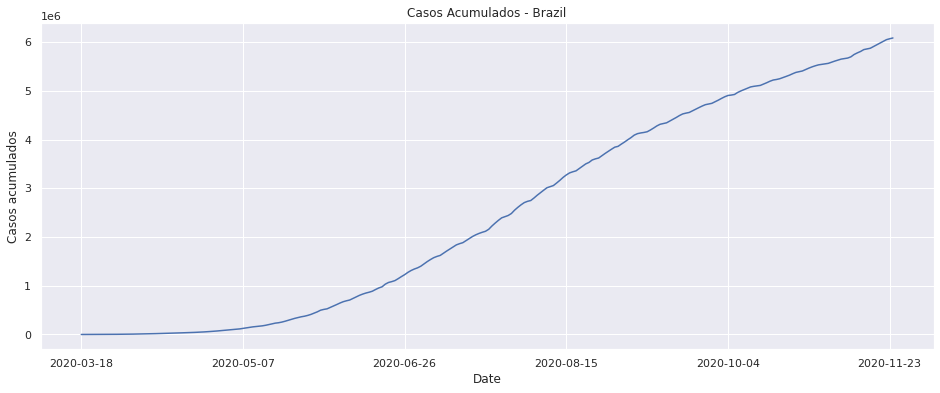

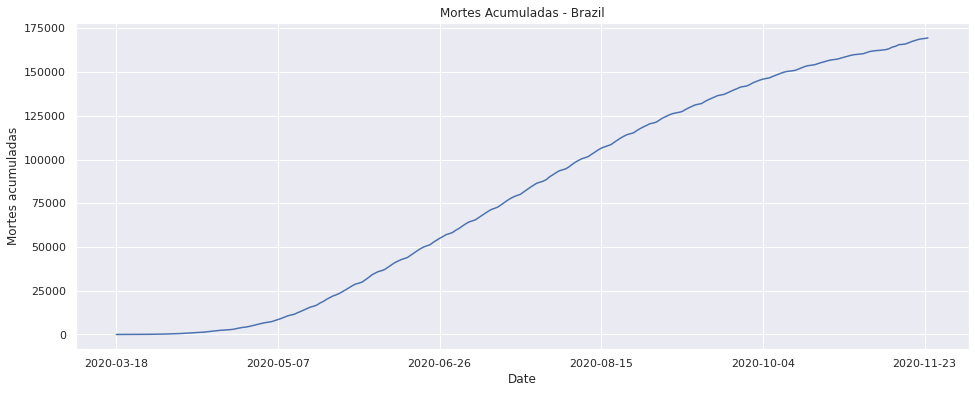

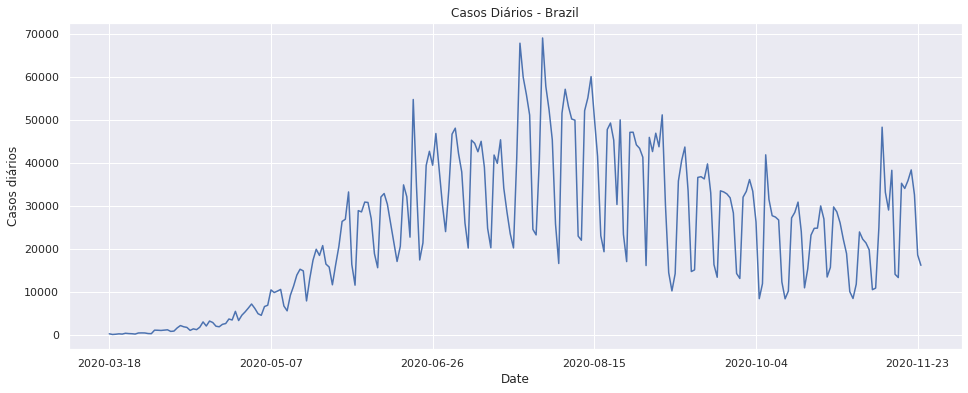

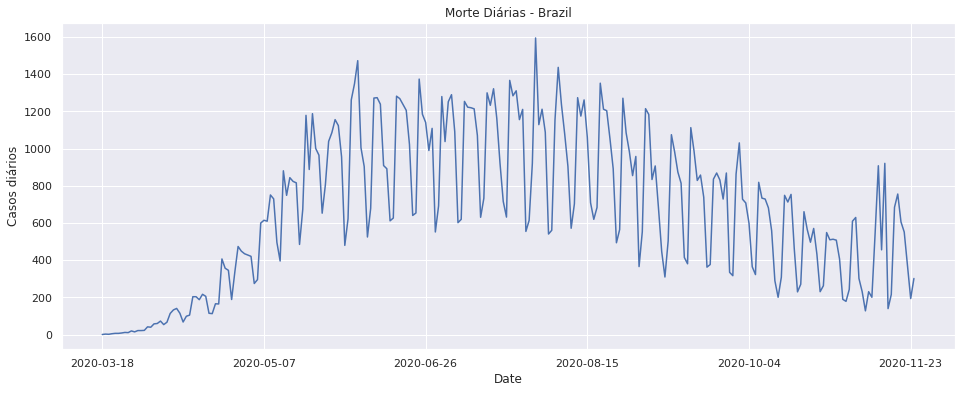

In [13]:
DF_PLOT_COVID_CHILE = DF_COVID.loc[DF_COVID['Country'] == 'Brazil'].set_index('Date')
plt.figure(figsize = (16,6))
DF_PLOT_COVID_CHILE.loc[:, 'Total'].plot()
plt.ylabel('Casos acumulados')
plt.title('Casos Acumulados - Brazil')
plt.show()

plt.figure(figsize = (16,6))
DF_PLOT_COVID_CHILE.loc[:, 'TotalDeaths'].plot()
plt.ylabel('Mortes acumuladas')
plt.title('Mortes Acumuladas - Brazil')
plt.show()

plt.figure(figsize = (16,6))
DF_PLOT_COVID_CHILE.loc[:, 'Daily'].plot()
plt.ylabel('Casos diários')
plt.title('Casos Diários - Brazil')
plt.show()

plt.figure(figsize = (16,6))
DF_PLOT_COVID_CHILE.loc[:, 'DailyDeaths'].plot()
plt.ylabel('Casos diários')
plt.title('Morte Diárias - Brazil')
plt.show()

### Puxando dados do índice de bolsa mais conhecido do Chile  e razão do câmbio em relação ao dólar pelo Investing.com

In [30]:
today=datetime.today()
date=today.strftime("%d/%m/%Y")
DF_FINANCE = pd.DataFrame(index = pd.date_range(start = '01/01/2020', end = date, freq='B'))
PAISES = ['Argentina', 'Brazil','Chile', 'Colombia', 'Peru', 'Mexico', 'Venezuela']
INDICES = ['S&P Merval', 'bovespa','S&P CLX IPSA','COLCAP', 'S&P Lima General', 'S&P/BMV IPC', 'Bursatil']
IND_PAIS = zip(PAISES,INDICES)
for pais, indice in IND_PAIS:
    DF_TEMP = ipy.get_index_historical_data(index = indice, country = pais, from_date = '01/01/2020', to_date = date)
    DF_CURRENCY = ipy.get_currency_cross_historical_data(currency_cross = 'USD/' + DF_TEMP['Currency'][0], from_date = '01/01/2020', to_date = date)[['Close']]
    DF_CURRENCY.rename(columns = {'Close':'{} Currency'.format(pais)}, inplace = True)
    DF_INDEX = DF_TEMP[['Close']].rename(columns = {'Close':'{} Stock Index'.format(pais)})
    DF_FINANCE_TEMP = DF_CURRENCY.join(DF_INDEX)
    DF_TEMP = DF_FINANCE_TEMP*100/DF_FINANCE_TEMP.shift(1) - 100
    DF_FINANCE_TEMP = DF_FINANCE_TEMP.join(DF_TEMP.rename(columns = {'{} Currency'.format(pais):'{} Currency Returns'.format(pais), '{} Stock Index'.format(pais):'{} Stock Index Returns'.format(pais)}))
    if (pais == 'Argentina'):
        DF_ARGENTINA_FINANCE = DF_FINANCE_TEMP
    elif (pais == 'Brazil'):
        DF_BRAZIL_FINANCE = DF_FINANCE_TEMP
    elif (pais == 'Chile'):
        DF_CHILE_FINANCE = DF_FINANCE_TEMP
    elif (pais == 'Colombia'):
        DF_COLOMBIA_FINANCE = DF_FINANCE_TEMP
    elif (pais == 'Peru'):
        DF_PERU_FINANCE = DF_FINANCE_TEMP
    elif (pais == 'Mexico'):
        DF_MEXICO_FINANCE = DF_FINANCE_TEMP
    elif (pais == 'Venezuela'):
        DF_VENEZUELA_FINANCE = DF_FINANCE_TEMP
    DF_FINANCE = DF_FINANCE.join(DF_FINANCE_TEMP)

In [22]:
DF_CHILE_FINANCE

Chile Currency  Chile Stock Index  Chile Currency Returns  \
Date                                                                    
2020-01-01          751.95                NaN                     NaN   
2020-01-02          749.28            4804.59               -0.355077   
2020-01-03          764.33            4839.70                2.008595   
2020-01-06          773.60            4884.39                1.212827   
2020-01-07          769.27            4913.36               -0.559721   
...                    ...                ...                     ...   
2020-11-18          758.08            4108.79               -0.642219   
2020-11-19          758.93            4028.30                0.112125   
2020-11-20          763.93            4054.53                0.658822   
2020-11-23          773.74            4131.26                1.284149   
2020-11-24          769.98            4152.81               -0.485951   

            Chile Stock Index Returns  
Date                                   
2020-01-01                        NaN  
2020-01-02                        NaN  
2020-01-03                   0.730760  
2020-01-06                   0.923404  
2020-01-07                   0.593114  
...                               ...  
2020-11-18                   1.364006  
2020-11-19                  -1.958971  
2020-11-20                   0.651143  
2020-11-23                   1.892451  
2020-11-24                   0.521633  

[235 rows x 4 columns]

In [30]:
DF_FINANCE

Argentina Currency  Argentina Stock Index  \
2020-01-01             59.8700                    NaN   
2020-01-02             59.8100               41106.97   
2020-01-03             59.7400               40499.15   
2020-01-06             59.7330               41469.66   
2020-01-07             59.7525               41115.71   
...                        ...                    ...   
2020-11-17             80.0300               51911.53   
2020-11-18             79.9910               51295.53   
2020-11-19             80.2700               50950.21   
2020-11-20             80.3500               51492.34   
2020-11-23             80.3000                    NaN   

            Argentina Currency Returns  Argentina Stock Index Returns  \
2020-01-01                         NaN                            NaN   
2020-01-02                   -0.100217                            NaN   
2020-01-03                   -0.117037                      -1.478630   
2020-01-06                   -0.011717                       2.396371   
2020-01-07                    0.032645                      -0.853516   
...                                ...                            ...   
2020-11-17                    0.100063                       1.618130   
2020-11-18                   -0.048732                      -1.186634   
2020-11-19                    0.348789                      -0.673197   
2020-11-20                    0.099664                       1.064039   
2020-11-23                   -0.062228                            NaN   

            Brazil Currency  Brazil Stock Index  Brazil Currency Returns  \
2020-01-01           4.0195                 NaN                      NaN   
2020-01-02           4.0263           118573.10                 0.169175   
2020-01-03           4.0672           117706.66                 1.015821   
2020-01-06           4.0618           116877.92                -0.132769   
2020-01-07           4.0679           116661.94                 0.150180   
...                     ...                 ...                      ...   
2020-11-17           5.3281           107248.63                -1.608436   
2020-11-18           5.3629           106119.09                 0.653141   
2020-11-19           5.3054           106669.90                -1.072181   
2020-11-20           5.3797           106042.48                 1.400460   
2020-11-23           5.4393           107378.92                 1.107868   

            Brazil Stock Index Returns  Chile Currency  Chile Stock Index  \
2020-01-01                         NaN          751.95                NaN   
2020-01-02                         NaN          749.28            4804.59   
2020-01-03                   -0.730722          764.33            4839.70   
2020-01-06                   -0.704072          773.60            4884.39   
2020-01-07                   -0.184791          769.27            4913.36   
...                                ...             ...                ...   
2020-11-17                    0.769248          762.98            4053.50   
2020-11-18                   -1.053198          758.08            4108.79   
2020-11-19                    0.519049          758.93            4028.30   
2020-11-20                   -0.588188          763.93            4054.53   
2020-11-23                    1.260287          773.94            4131.26   

            Chile Currency Returns  Chile Stock Index Returns  \
2020-01-01                     NaN                        NaN   
2020-01-02               -0.355077                        NaN   
2020-01-03                2.008595                   0.730760   
2020-01-06                1.212827                   0.923404   
2020-01-07               -0.559721                   0.593114   
...                            ...                        ...   
2020-11-17               -0.407258                   0.150219   
2020-11-18               -0.642219                   1.364006   
2020-11-19                0

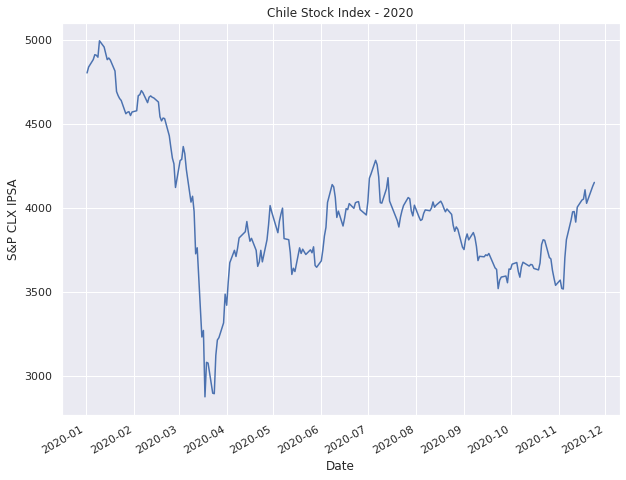

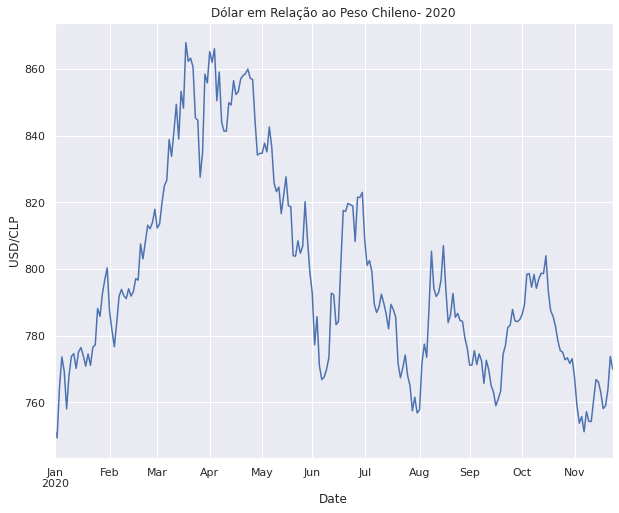

In [15]:
plt.figure(figsize = (10,8))
DF_CHILE_FINANCE['Chile Stock Index'].dropna().plot()
plt.ylabel('S&P CLX IPSA')
plt.title('Chile Stock Index - 2020')
plt.show()

plt.figure(figsize = (10,8))
DF_CHILE_FINANCE['Chile Currency'].plot()
plt.ylabel('USD/CLP')
plt.title('Dólar em Relação ao Peso Chileno- 2020')
plt.show()

### Adicionando-se os retornos tanto da moeda quanto do índice de bolsa

In [39]:
DF_TEMP = DF_CHILE_FINANCE*100/DF_CHILE_FINANCE.shift(1) - 100
DF_CHILE_FINANCE = DF_CHILE_FINANCE.join(DF_TEMP.rename(columns = {'Chile Currency':'Currency Returns', 'Chile Stock Index':'Chile Stock Index Returns'}))

ValueError: columns overlap but no suffix specified: Index(['Chile Currency Returns', 'Chile Stock Index Returns',
       'Chile Stock Index Returns'],
      dtype='object')

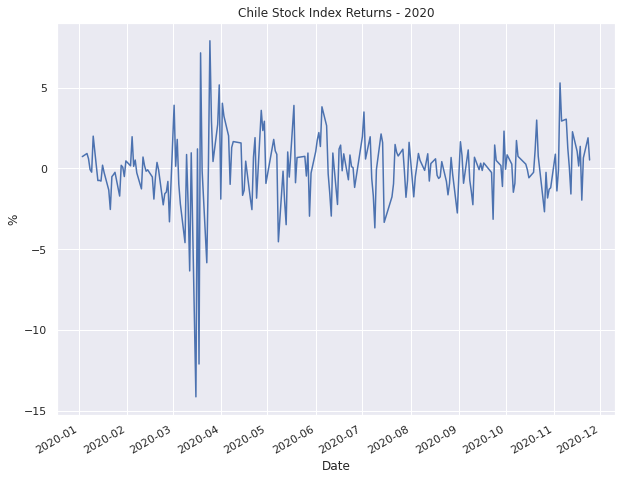

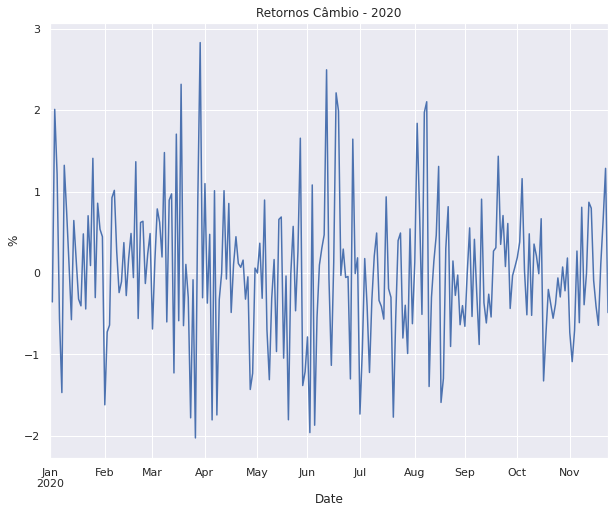

In [17]:
plt.figure(figsize = (10,8))
DF_CHILE_FINANCE['Chile Stock Index Returns'].dropna().plot()
plt.ylabel('%')
plt.title('Chile Stock Index Returns - 2020')
plt.show()

plt.figure(figsize = (10,8))
DF_CHILE_FINANCE['Chile Currency Returns'].plot()
plt.ylabel('%')
plt.title('Retornos Câmbio - 2020')
plt.show()

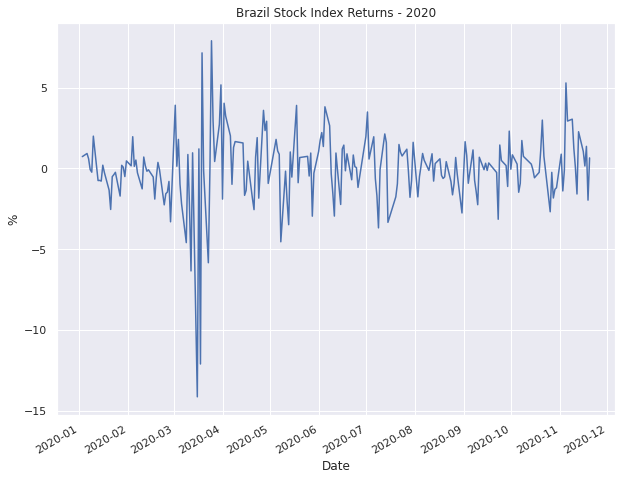

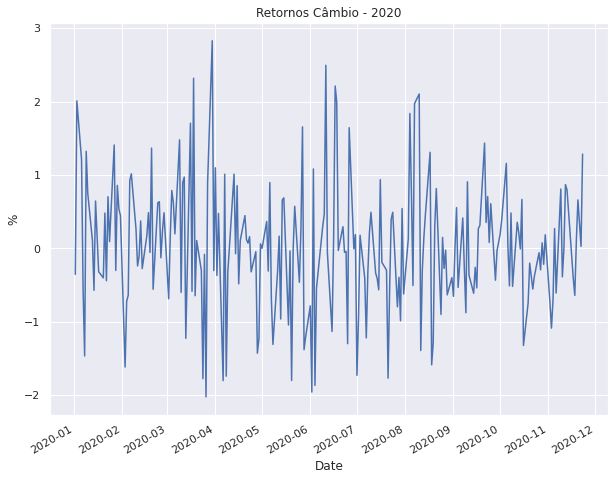

In [46]:
plt.figure(figsize = (10,8))
DF_CHILE_FINANCE['Chile Stock Index Returns'].dropna().plot()
plt.ylabel('%')
plt.title('Brazil Stock Index Returns - 2020')
plt.show()

plt.figure(figsize = (10,8))
DF_CHILE_FINANCE['Chile Currency Returns'].plot()
plt.ylabel('%')
plt.title('Retornos Câmbio - 2020')
plt.show()

### Encontrando datas que podem ser interessantes usando variações absolutas nos preços de ações maiores que 3% para verificar nas notícias de cunho financeiro para verificar se tem alguma relação com o covid ou outro. 

In [28]:
DF_BRAZIL_FINANCE.loc[((DF_BRAZIL_FINANCE['Brazil Stock Index Returns'] >= 2.5) | (DF_BRAZIL_FINANCE['Brazil Stock Index Returns'] <= -2.5))]

Brazil Currency  Brazil Stock Index  Brazil Currency Returns  \
Date                                                                       
2020-01-27           4.2077           114481.84                 0.621757   
2020-02-27           4.4863           102983.54                 0.804404   
2020-03-05           4.6076           102233.24                 0.492912   
2020-03-06           4.6272            97996.77                 0.425384   
2020-03-09           4.7246            86067.20                 2.104945   
2020-03-10           4.6439            92214.47                -1.708081   
2020-03-11           4.8152            85171.13                 3.688710   
2020-03-12           4.7916            72582.53                -0.490115   
2020-03-13           4.8595            82677.91                 1.417063   
2020-03-16           5.0005            71168.05                 2.901533   
2020-03-17           5.0100            74617.24                 0.189981   
2020-03-18           5.1075            66894.95                 1.946108   
2020-03-23           5.1446            63569.62                 1.591627   
2020-03-24           5.0995            69729.30                -0.876647   
2020-03-25           5.0366            74955.57                -1.233454   
2020-03-26           5.0219            77709.66                -0.291864   
2020-03-27           5.1005            73428.78                 1.565145   
2020-04-01           5.2495            70966.70                 0.849135   
2020-04-03           5.3509            69537.56                 1.852063   
2020-04-06           5.2873            74072.98                -1.188585   
2020-04-07           5.2229            76358.09                -1.218013   
2020-04-08           5.1241            78624.62                -1.891669   
2020-04-24           5.5915            75330.61                 1.017127   
2020-04-27           5.6543            78238.60                 1.123133   
2020-04-28           5.5012            81312.23                -2.707674   
2020-04-30           5.4875            80505.89                 2.837278   
2020-05-08           5.7329            80263.35                -1.705987   
2020-05-18           5.7204            81194.29                -2.332252   
2020-05-25           5.4467            85663.48                -1.577521   
2020-05-27           5.2743            87946.25                -1.341190   
2020-06-02           5.2017            91046.38                -3.043802   
2020-06-08           4.8235            97644.67                -2.736328   
2020-08-31           5.4925            99369.15                 1.937603   
2020-09-01           5.3960           102167.65                -1.756941   
2020-10-08           5.5987            97919.73                -0.196089   
2020-10-28           5.7457            95368.76                 0.704583   
2020-10-30           5.7446            93952.40                -0.595259   
2020-11-05           5.5250           100751.40                -2.445484   
2020-11-09           5.3858           103515.16                 0.393312   

            Brazil Stock Index Returns  
Date                                    
2020-01-27                   -3.289947  
2020-02-27                   -2.586828  
2020-03-05                   -4.654713  
2020-03-06                   -4.143926  
2020-03-09                  -12.173432  
2020-03-10                    7.142407  
2020-03-11                   -7.637999  
2020-03-12                  -14.780360  
2020-03-13                   13.908829  
2020-03-16                  -13.921324  
2020-03-17                    4.846543  
2020-03-18                  -10.349203  
2020-03-23                   -5.218091  
2020-03-24                    9.689660  
2020-03-25                    7.495085  
2020-03-26                    3.674297  
2020-03-27                   -5.508813  
2020-04-01                   -2.811650  
2020-04-03                   -3.758851  
2020-04-06                    6.52

### Dados Macroeconômicos - Todos do https://tradingeconomics.com/chile

### GDP

In [171]:
CHILE_GDP_YEAR_GROWTH = [1.9, 2.6, 4.5, 5.3, 2.8, 3.3, 1.4, 1.8, 3.4, -2.1, 0.2, -14.1]
CHILE_GDP_Q_GROWTH = [1.9, 0.9, 1.3, 0.9, -0.1, 1.0, 0.1, 0.8, 0.8, -4.1, 3, -13.2]
CHILE_GFCI = [7416.986, 9024.973, 7341.969, 7765.248, 7812.535, 9610.458, 7644.751, 8169.501, 8211.655,9868.753, 7683.343, 6937.97] # GROSS FIXED CAPITAL FORMATION
date_index = pd.date_range('2017-07', periods=12, freq='Q')
DF_GDP_CHILE = pd.DataFrame(index = date_index, data = {'GDP_YEAR_GROWTH' : CHILE_GDP_YEAR_GROWTH, 'GDP_Q_GROWTH' : CHILE_GDP_Q_GROWTH, 'GROSS_FIXED_CAPITAL_FORMATION': CHILE_GFCI})


In [172]:
DF_GDP_CHILE

GDP YEAR GROWTH  GDP Q GROWTH  GROSS FIXED CAPITAL FORMATION
2017-09-30              1.9           1.9                       7416.986
2017-12-31              2.6           0.9                       9024.973
2018-03-31              4.5           1.3                       7341.969
2018-06-30              5.3           0.9                       7765.248
2018-09-30              2.8          -0.1                       7812.535
2018-12-31              3.3           1.0                       9610.458
2019-03-31              1.4           0.1                       7644.751
2019-06-30              1.8           0.8                       8169.501
2019-09-30              3.4           0.8                       8211.655
2019-12-31             -2.1          -4.1                       9868.753
2020-03-31              0.2           3.0                       7683.343
2020-06-30            -14.1         -13.2                       6937.970

In [165]:
pd.date_range('2017-07', periods=12, freq='Q')

DatetimeIndex(['2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30',
               '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30',
               '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30'],
              dtype='datetime64[ns]', freq='Q-DEC')

### Valor Agregado do PIB por atividade econômica 2019 - https://estadisticas.cepal.org/cepalstat/Perfil_Nacional_Economico.html?pais=CHL&idioma=spanish

In [211]:
Pais = ['Pais', 'Eletrecidade_Agua_Gas', 'Agropecuario', 'Construcao', 'Transporte_Comunicacao', 'Mineracao', 'Manufatura', 'Comercio', 'Administracao Publica', 'Intermediacao inanceira']
Dados = np.array(['Chile', 3.3, 3.9, 7.5, 7.7, 10.2, 11.0, 12.3, 18.7, 25.3]).reshape(-1,10)
DF_ECONOMIC_ACTIVITIES_GDP = pd.DataFrame(columns = Pais, data = Dados)

In [212]:
DF_ECONOMIC_ACTIVITIES_GDP

Pais Eletrecidade_Agua_Gas Agropecuario Construcao Transporte_Comunicacao  \
0  Chile                   3.3          3.9        7.5                    7.7   

  Mineracao Manufatura Comercio Administracao Publica Intermediacao inanceira  
0      10.2       11.0     12.3                  18.7                    25.3

### Desemprego e Inflação

In [173]:
CHILE_UNEMPLOYMENT = [7.3, 7.1, 7.0, 7.1, 7.4, 7.8, 8.2, 9, 11.2, 12.2, 13.1, 12.9]
CHILE_INFLATION_YEAR_RATE = [2.5, 2.7, 3, 3.5, 3.9, 3.7, 3.4, 2.8, 2.6, 2.5, 2.4, 3.1]
CHILE_INFLATION_MONTH_RATE = [0.8, 0.1, 0.1, 0.6, 0.4, 0.3, 0.0, -0.1, -0.1, 0.1, 0.1, 0.6]
CHILE_INFLATION_CPI = [103.47, 103.55, 103.66, 104.32, 104.71, 105.06, 105.01, 104.96, 104.89, 104.99, 105.13, 105.8]

date_index = pd.date_range('2019-09', periods=12, freq='M')
DF_CHILE_UNEMPLOYMENT = pd.DataFrame(index = date_index, data = {'UNEMPLOYMENT' : CHILE_UNEMPLOYMENT})
date_index = pd.date_range('2019-10', periods=12, freq='M')
DF_CHILE_INFLATION = pd.DataFrame(index = date_index, data = {'INFLATION_YEAR_RATE' : CHILE_INFLATION_YEAR_RATE,
                                                              'INFLATION_MONTH_RATE' : CHILE_INFLATION_MONTH_RATE,
                                                              'INFLATION_CPI': CHILE_INFLATION_CPI})

In [174]:
DF_CHILE_UNEMPLOYMENT

UNEMPLOYMENT
2019-09-30           7.3
2019-10-31           7.1
2019-11-30           7.0
2019-12-31           7.1
2020-01-31           7.4
2020-02-29           7.8
2020-03-31           8.2
2020-04-30           9.0
2020-05-31          11.2
2020-06-30          12.2
2020-07-31          13.1
2020-08-31          12.9

In [175]:
DF_CHILE_INFLATION

INFLATION_YEAR_RATE  INFLATION_MONTH_RATE  INFLATION_CPI
2019-10-31                  2.5                   0.8         103.47
2019-11-30                  2.7                   0.1         103.55
2019-12-31                  3.0                   0.1         103.66
2020-01-31                  3.5                   0.6         104.32
2020-02-29                  3.9                   0.4         104.71
2020-03-31                  3.7                   0.3         105.06
2020-04-30                  3.4                   0.0         105.01
2020-05-31                  2.8                  -0.1         104.96
2020-06-30                  2.6                  -0.1         104.89
2020-07-31                  2.5                   0.1         104.99
2020-08-31                  2.4                   0.1         105.13
2020-09-30                  3.1                   0.6         105.80

### COMPOSITE lEADING INDICATOR (CLI) - OCDE - https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart

In [199]:
df_orig = pd.read_csv(data_dir + 'economic\CLI_CHILE_2017.csv')
DF_CLI_CHILE = df_orig.loc[df_orig['LOCATION'] == 'CHL', ['TIME', 'Value']].rename(columns = {'TIME': 'Date'}).set_index('Date')

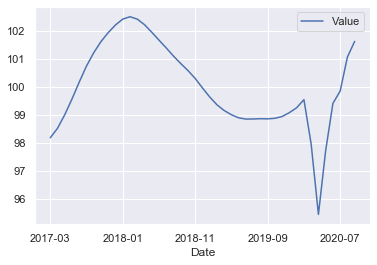

In [201]:
DF_CLI_CHILE.plot()

### Confiança do consumidor e do empresário - https://tradingeconomics.com/chile

In [176]:
CHILE_CONSUMER_CONFIDENCE = [38.6, 36.7, 28.3, 29.4, 30.4, 32.7, 27.8, 21.6, 21.2, 20.3, 21.2, 25.5]
CHILE_BUSINESS_CONFIDENCE = [51.52, 36.58, 32.53, 40.67, 43.91, 40.7, 31.74, 34.28, 37.3, 37.8, 42.51, 49.81]

date_index = pd.date_range('2019-10', periods=12, freq='M')
DF_CHILE_CONFIDENCE = pd.DataFrame(index = date_index, data = {'CONSUMER_CONFIDENCE' : CHILE_CONSUMER_CONFIDENCE,
                                                               'BUSINESS_CONFIDENCE' : CHILE_BUSINESS_CONFIDENCE})

In [184]:
DF_CHILE_CONFIDENCE

CONSUMER_CONFIDENCE  BUSINESS_CONFIDENCE
2019-10-31                 38.6                51.52
2019-11-30                 36.7                36.58
2019-12-31                 28.3                32.53
2020-01-31                 29.4                40.67
2020-02-29                 30.4                43.91
2020-03-31                 32.7                40.70
2020-04-30                 27.8                31.74
2020-05-31                 21.6                34.28
2020-06-30                 21.2                37.30
2020-07-31                 20.3                37.80
2020-08-31                 21.2                42.51
2020-09-30                 25.5                49.81

### Qualidade do Ar - https://aqicn.org/data-platform/covid19/

In [3]:
df_orig = pd.read_csv(data_dir + 'air-quality\waqi-covid19-airqualitydata-2020.csv', header = 4)

FileNotFoundError: [Errno 2] File ../../data/air-quality\waqi-covid19-airqualitydata-2020.csv does not exist: '../../data/air-quality\\waqi-covid19-airqualitydata-2020.csv'

In [136]:
df_orig = df_orig.loc[df_orig['Country'] == 'CL']
df_orig.loc[df_orig['Country'] == 'CL', 'Country'] = 'Chile'
df_orig = df_orig.loc[df_orig['Specie'].isin(['pm25', 'no2', 'co', 'pm10', 'o3', 'so2'])]


In [138]:
df_grouped = df_orig.groupby(['Date', 'Country', 'Specie']).mean()
DF_CHILE_AIR_QUALITY = df_grouped.reset_index()
DF_CHILE_AIR_QUALITY['City'] = 'All cities in dataset'


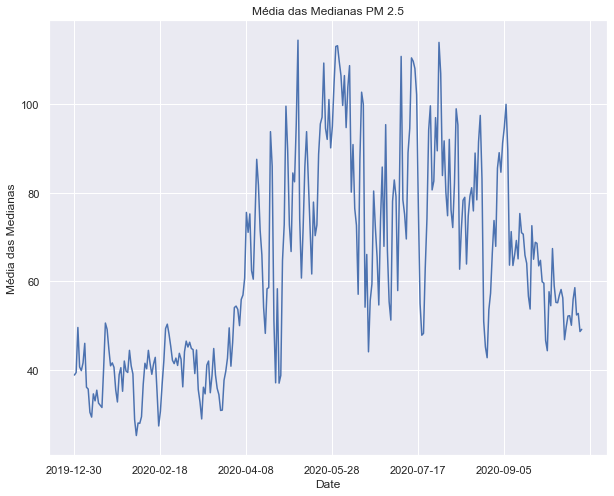

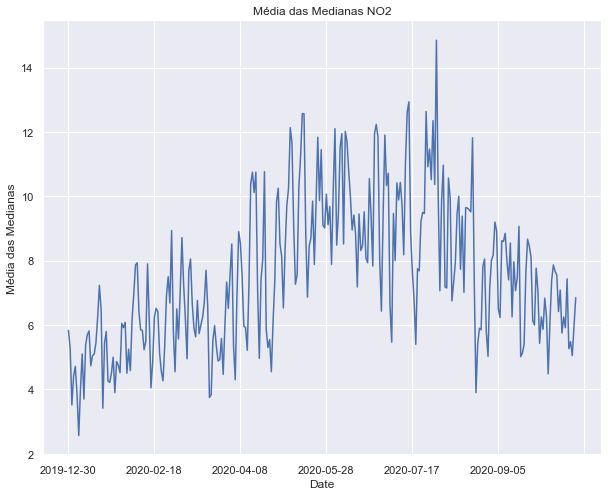

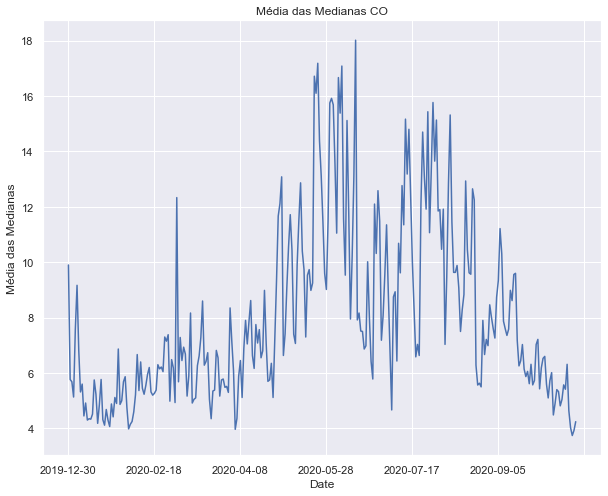

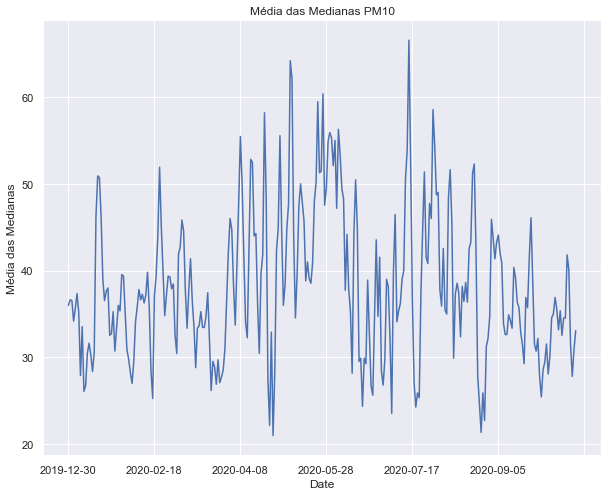

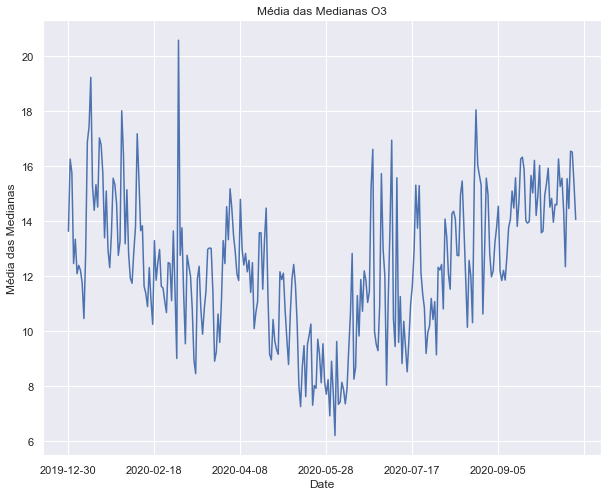

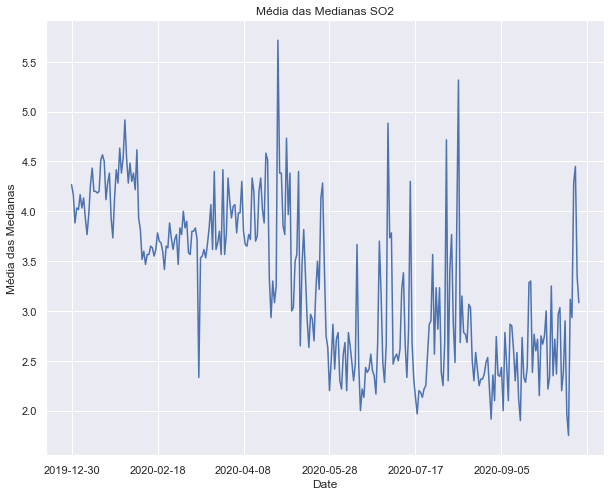

In [155]:
DF_CHILE_PM25 = DF_CHILE_AIR_QUALITY.loc[DF_CHILE_AIR_QUALITY['Specie'] == 'pm25'].set_index('Date')
plt.figure(figsize = (10,8))
DF_CHILE_PM25['median'].plot()
plt.ylabel('Média das Medianas')
plt.title('Média das Medianas PM 2.5')
plt.show()

DF_CHILE_NO2 = DF_CHILE_AIR_QUALITY.loc[DF_CHILE_AIR_QUALITY['Specie'] == 'no2'].set_index('Date')
plt.figure(figsize = (10,8))
DF_CHILE_NO2['median'].plot()
plt.ylabel('Média das Medianas')
plt.title('Média das Medianas NO2')
plt.show()

DF_CHILE_CO = DF_CHILE_AIR_QUALITY.loc[DF_CHILE_AIR_QUALITY['Specie'] == 'co'].set_index('Date')
plt.figure(figsize = (10,8))
DF_CHILE_CO['median'].plot()
plt.ylabel('Média das Medianas')
plt.title('Média das Medianas CO')
plt.show()

DF_CHILE_PM10 = DF_CHILE_AIR_QUALITY.loc[DF_CHILE_AIR_QUALITY['Specie'] == 'pm10'].set_index('Date')
plt.figure(figsize = (10,8))
DF_CHILE_PM10['median'].plot()
plt.ylabel('Média das Medianas')
plt.title('Média das Medianas PM10')
plt.show()

DF_CHILE_O3 = DF_CHILE_AIR_QUALITY.loc[DF_CHILE_AIR_QUALITY['Specie'] == 'o3'].set_index('Date')
plt.figure(figsize = (10,8))
DF_CHILE_O3['median'].plot()
plt.ylabel('Média das Medianas')
plt.title('Média das Medianas O3')
plt.show()

DF_CHILE_so2 = DF_CHILE_AIR_QUALITY.loc[DF_CHILE_AIR_QUALITY['Specie'] == 'so2'].set_index('Date')
plt.figure(figsize = (10,8))
DF_CHILE_so2['median'].plot()
plt.ylabel('Média das Medianas')
plt.title('Média das Medianas SO2')
plt.show()

### Dados de locomoção do Google - https://www.google.com/covid19/mobility/

In [5]:
df_orig = pd.read_csv('2020_BR_Region_Mobility_Report.csv')

FileNotFoundError: [Errno 2] File 2020_BR_Region_Mobility_Report.csv does not exist: '2020_BR_Region_Mobility_Report.csv'

In [162]:
DF_GOOGLE_MOBILITY_CHILE = df_orig.loc[df_orig['sub_region_1'].isnull()].set_index('date')

In [163]:
df_orig.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

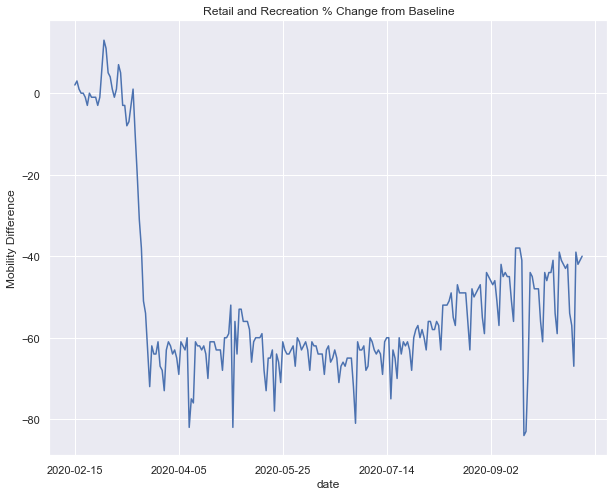

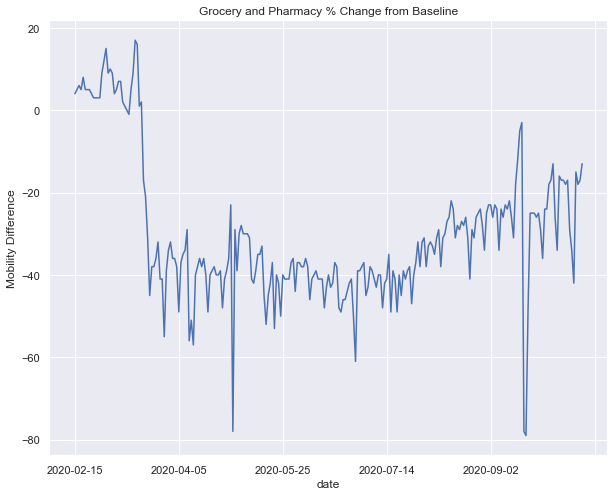

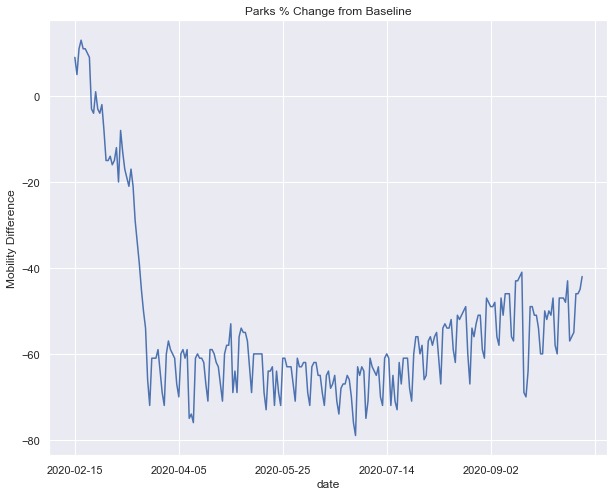

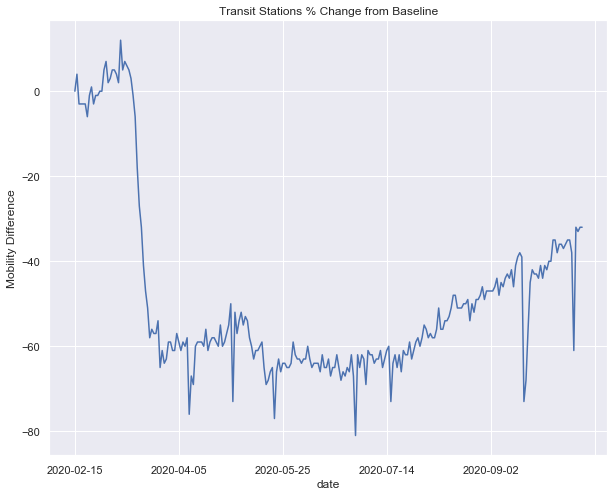

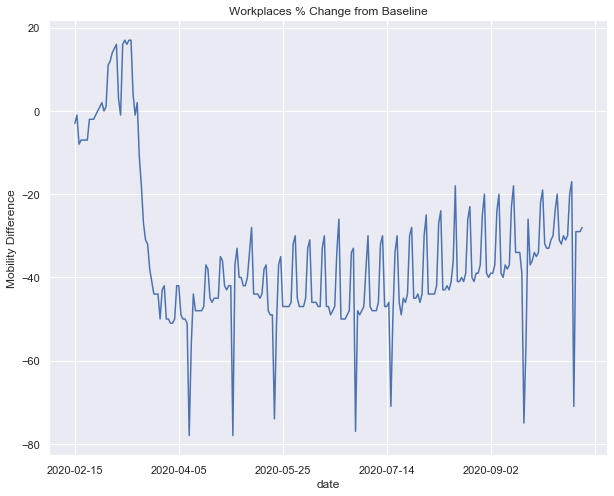

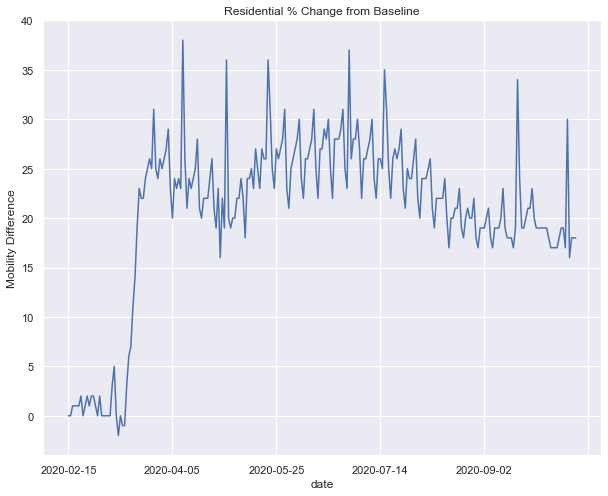

In [164]:
plt.figure(figsize = (10,8))
DF_GOOGLE_MOBILITY_CHILE['retail_and_recreation_percent_change_from_baseline'].plot()
plt.ylabel('Mobility Difference')
plt.title('Retail and Recreation % Change from Baseline')
plt.show()

plt.figure(figsize = (10,8))
DF_GOOGLE_MOBILITY_CHILE['grocery_and_pharmacy_percent_change_from_baseline'].plot()
plt.ylabel('Mobility Difference')
plt.title('Grocery and Pharmacy % Change from Baseline')
plt.show()

plt.figure(figsize = (10,8))
DF_GOOGLE_MOBILITY_CHILE['parks_percent_change_from_baseline'].plot()
plt.ylabel('Mobility Difference')
plt.title('Parks % Change from Baseline')
plt.show()

plt.figure(figsize = (10,8))
DF_GOOGLE_MOBILITY_CHILE['transit_stations_percent_change_from_baseline'].plot()
plt.ylabel('Mobility Difference')
plt.title('Transit Stations % Change from Baseline')
plt.show()

plt.figure(figsize = (10,8))
DF_GOOGLE_MOBILITY_CHILE['workplaces_percent_change_from_baseline'].plot()
plt.ylabel('Mobility Difference')
plt.title('Workplaces % Change from Baseline')
plt.show()

plt.figure(figsize = (10,8))
DF_GOOGLE_MOBILITY_CHILE['residential_percent_change_from_baseline'].plot()
plt.ylabel('Mobility Difference')
plt.title('Residential % Change from Baseline')
plt.show()